In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
plt.style.use('seaborn')

# Data Science
import numpy as np
import pandas as pd
import xarray

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key("")
# fa2c25ad3d9f4756bbd105a761f0671b

# Others
import requests
import rich.table
from itertools import cycle
from tqdm.notebook import tqdm
tqdm.pandas()

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [4]:
crop_presence_data = pd.read_csv("../Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [5]:
sample_sub = pd.read_csv("../challenge_1_submission_template.csv")
sample_sub.head()

,Latitude and Longitude
0,"(10.18019073690894, 105.32022315786804)"
1,"(10.561107033461816, 105.12772097986661)"
2,"(10.623790611954897, 105.13771401411867)"
3,"(10.583364246115156, 105.23946127195805)"
4,"(10.20744446668854, 105.26844107128906)"


# EDA

In [6]:
crop_presence_data.shape, sample_sub.shape

((600, 2), (250, 1))

<AxesSubplot: >

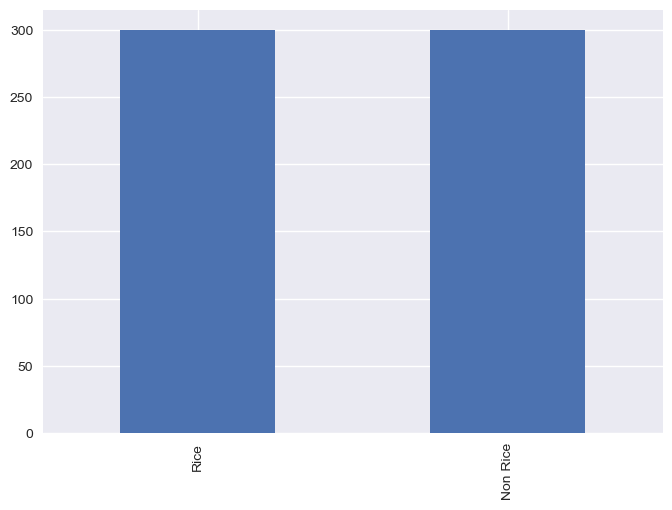

In [7]:
crop_presence_data['Class of Land'].value_counts().plot.bar()

## Area Visualization

In [8]:
# function to extract latitude and longitude numbers from string
def get_lat_lon(df):
    return pd.DataFrame([df.iloc[:, 0].apply(lambda x:x.split(', ')[0][1: ]).astype(float),
                        df.iloc[:, 0].apply(lambda x:x.split(', ')[1][:-1]).astype(float)],
                        index=['latitude', 'longitude']).T

In [9]:
# Add latitude and longitude to train data
crop_presence_data[['latitude', 'longitude']] = get_lat_lon(crop_presence_data)
crop_presence_data.head(2)

,Latitude and Longitude,Class of Land,latitude,longitude
0,"(10.323727047081501, 105.2516346045924)",Rice,10.323727,105.251635
1,"(10.322364360592521, 105.27843410554115)",Rice,10.322364,105.278434


In [10]:
# Add latitude and longitude to submission data
sample_sub[['latitude', 'longitude']] = get_lat_lon(sample_sub)
sample_sub.head(2)

,Latitude and Longitude,latitude,longitude
0,"(10.18019073690894, 105.32022315786804)",10.180191,105.320223
1,"(10.561107033461816, 105.12772097986661)",10.561107,105.127721


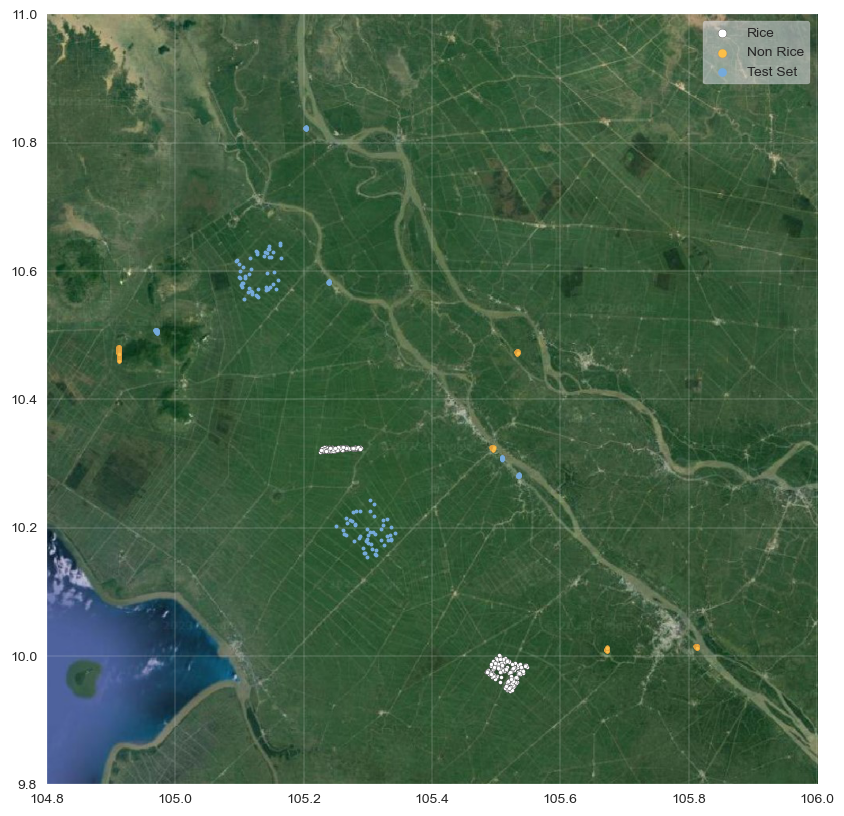

In [73]:
# Plot locations on top of map

plt.scatter(crop_presence_data[crop_presence_data['Class of Land'] == 'Rice'].longitude, crop_presence_data[crop_presence_data['Class of Land'] == 'Rice'].latitude,
            s=8, c='white', label='Rice', lw=0.2, ec='k')
plt.scatter(crop_presence_data[crop_presence_data['Class of Land'] != 'Rice'].longitude, crop_presence_data[crop_presence_data['Class of Land'] != 'Rice'].latitude,
            s=8, label='Non Rice', lw=0.05, ec='#843511', c='#FCBF49')
plt.scatter(sample_sub.longitude, sample_sub.latitude, s=8, c='#75AADB', label='Test Set', lw=0, ec='k')

fig = plt.gcf()
ax  = plt.gca()

fig.set_size_inches(10, 10)

ax.set_aspect('equal')
ax.patch.set_alpha(0)
plt.grid(lw=0.15)
legend = plt.legend(framealpha=0.5, frameon=True)
legend.legendHandles[0]._sizes = [40]
legend.legendHandles[1]._sizes = [40]
legend.legendHandles[2]._sizes = [40]
# legend.set_alpha(0)

plt.xlim(104.8, 106)
plt.ylim(9.8, 11)

# [0.06, 0, 0.95, 0.95]

newax = fig.add_axes(ax.get_position(), anchor='SW', zorder=-15)
# newax.set_position(ax.get_position())
newax.imshow(plt.imread('../Full Region no labels.jpg'), aspect='auto')
newax.axis('off')
plt.grid(False)

# Getting Data Functions

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

## Accessing the Sentinel-1 Data

In [74]:
def get_sentinel_data(lat_long, time_of_interest, box_size_deg = 4*10**-4):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    lat_long - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    '''
    lat_long = lat_long.replace('(','').replace(')','').split(', ')
    
    # Surrounding box in degrees, yields approximately 5x5 pixel region
    
    min_lon = float(lat_long[1])-box_size_deg/2
    min_lat = float(lat_long[0])-box_size_deg/2
    max_lon = float(lat_long[1])+box_size_deg/2
    max_lat = float(lat_long[0])+box_size_deg/2

    bbox_of_interest = (min_lon , min_lat, max_lon, max_lat)
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    
    items = list(search.get_all_items())
    
    data = stac_load(items, bands=("vh", "vv"), patch_url=pc.sign, bbox=bbox_of_interest, progress=tqdm)
    # vh = data["vh"].astype("float").values.tolist()[0][0]
    # vv = data["vv"].astype("float").values.tolist()[0][0]
    return data

In [75]:
# Calculate RVI
def RVI(nparray):
    '''
    Calculates RVI (Radar Vegetation Index) with VH and VV values from a numpy array.
    nparray has to have VH in the first column and VV in the second column.
    '''
    vh = nparray[:, 0]
    vv = nparray[:, 1]
    dop = vh / (vv + vh)
    return 4*dop**1.5

In [77]:
# Create Pipeline
def GetPrepareData(x, time_slice):
    '''
    Gets VH and VV data by calling the function get_sentinel_data for the given locations and for a given time frame,
    calculate RVI and return a MultiIndex DataFrame with a time-series for each feature for each location.
    
    x is a Series of latitudes and longitudes
    time_slice is in the format "yyyy-mm-dd/yyyy-mm-dd"
    '''
    
    data_series = x.progress_apply(get_sentinel_data, args=[time_slice])
    
    vh_ts = data_series.apply(lambda x:pd.Series(x[assets[0]].mean(2).mean(1).values), index=x[assets[0]].time).reset_index(drop=True).stack().rename('vh')    
    vv_ts = data_series.apply(lambda x:pd.Series(x[assets[1]].mean(2).mean(1).values), index=x[assets[1]].time).reset_index(drop=True).stack().rename('vv')
    
    # concat vh and vv into dataframe.
    # create extra metrics based on vh and vv
    data_df = pd.concat([vh_ts, vv_ts], axis=1)
    
    data_df = data_df.assign(rvi=lambda x:RVI(x.values))
    
    return data_df.assign(rvi=lambda x:RVI(x.values))

### Testing with 5 locations and 2 days of data

In [79]:
# GetPrepareData(crop_presence_data['Latitude and Longitude'].head(2), "2020-03-20/2020-03-30")

# Processing Data

In [2319]:
# train_data = GetPrepareData(crop_presence_data['Latitude and Longitude'].head(), "2021-11-01/2022-08-31")

In [161]:
train_data = pd.read_csv('../train_data_box.csv', index_col=['index', 'datetime'], parse_dates=True)
sub_data   = pd.read_csv(  '../sub_data_box.csv', index_col=['index', 'datetime'], parse_dates=True)
display(train_data.head(), sub_data.head())

vh        vv       rvi
index datetime                                                
0     2021-11-04 22:45:36.411115  0.039149  0.085078  0.707640
      2021-11-10 22:46:08.655270  0.034205  0.103747  0.493852
      2021-11-11 11:11:55.398152  0.044161  0.141528  0.463913
      2021-11-16 22:45:36.313857  0.029956  0.116194  0.371190
      2021-11-22 22:46:08.483277  0.032765  0.226458  0.179748

vh        vv       rvi
index datetime                                                
0     2021-11-04 22:45:36.411115  0.004684  0.010618  0.677478
      2021-11-10 22:46:08.655270  0.007894  0.008727  1.309242
      2021-11-11 11:11:55.398152  0.004270  0.011400  0.569015
      2021-11-16 22:45:36.313857  0.003723  0.011042  0.506417
      2021-11-22 22:46:08.483277  0.006572  0.015097  0.668099

In [162]:
def is_outlier(series, factor=1, print_range=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR*factor
    upper_bound = Q3 + 1.5 * IQR*factor
    if print_range:
        print(upper_bound, lower_bound)
    boolean_filter = (series < lower_bound) | (series > upper_bound)
    return pd.Series(np.where(boolean_filter,
                                       np.nan,
                                       series),
                              index=series.index)

<AxesSubplot: >

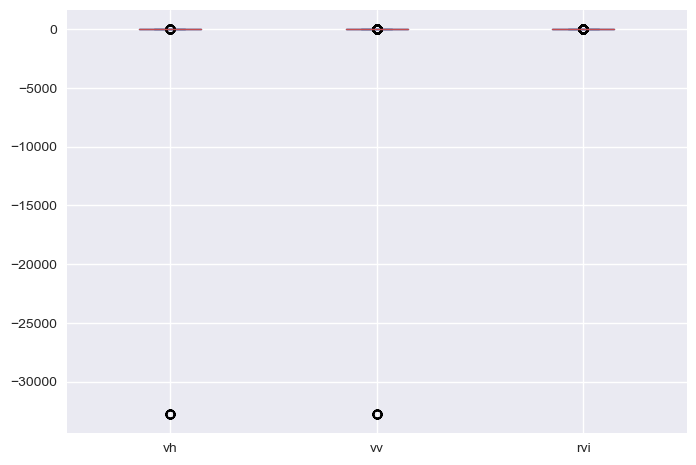

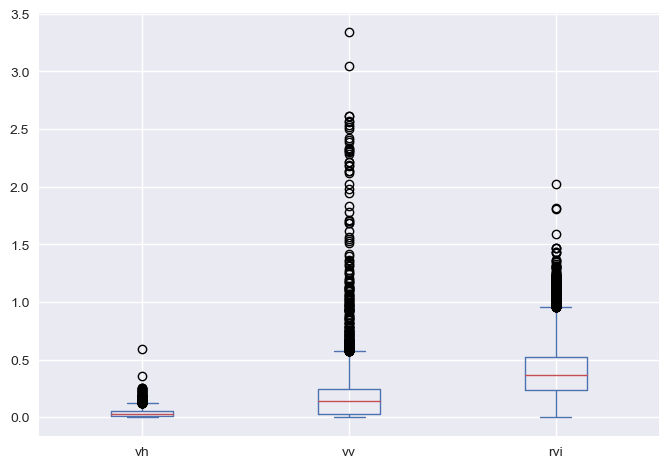

In [163]:
# Check boxplot with different outliers filters
train_data.plot.box()
sub_data.plot.box()

In [164]:
train_data = train_data.apply(is_outlier, args=[10])
sub_data   = sub_data.apply(  is_outlier, args=[10])

<AxesSubplot: >

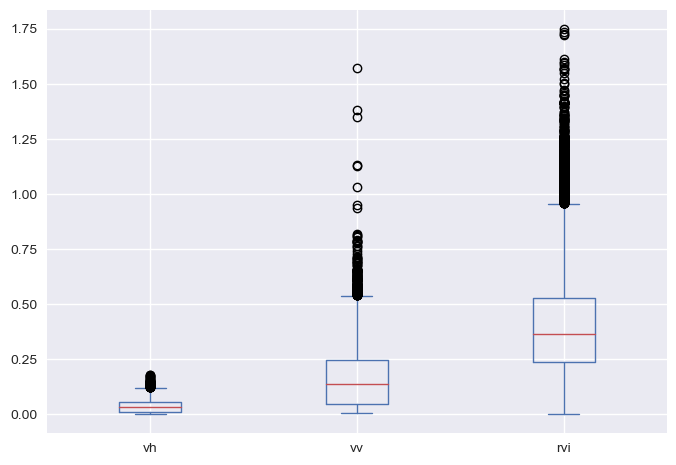

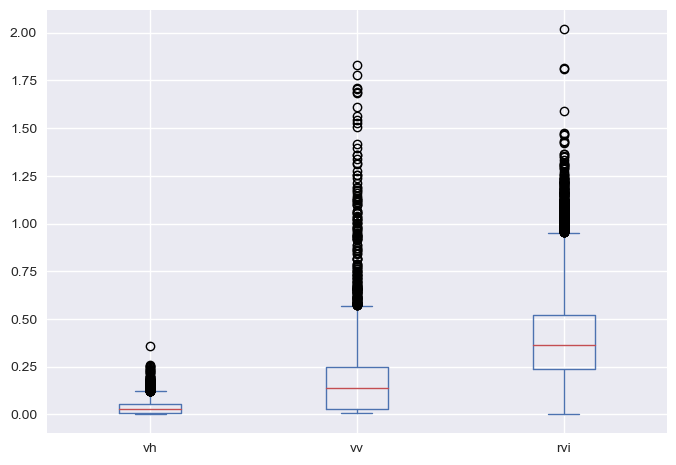

In [165]:
# Check boxplot after outlier filters
train_data.plot.box()
sub_data.plot.box()

<AxesSubplot: xlabel='datetime'>

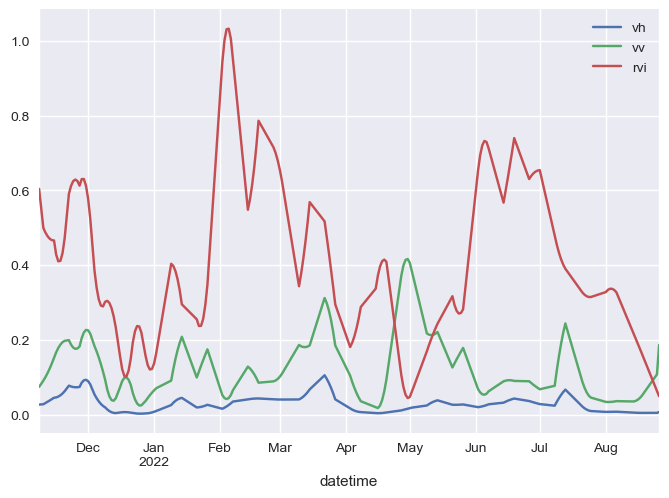

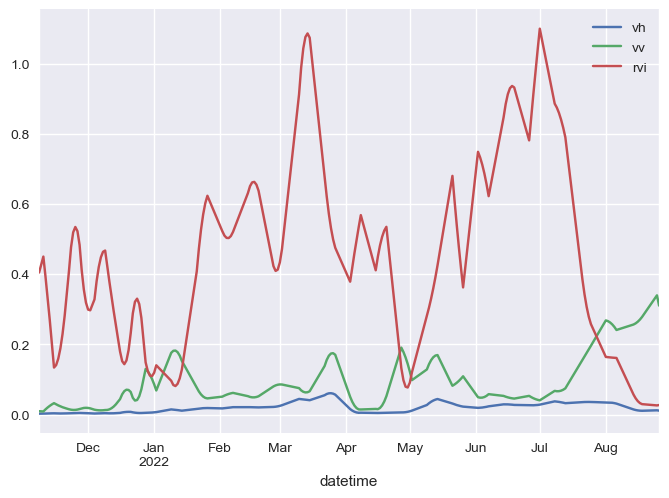

In [182]:
# interpolate all datetimes
# for that we unstack the index, do the interpolation, then restack
train_data = train_data.unstack(level=0).resample('1d').mean().interpolate().bfill().stack().swaplevel().sort_index(level=0).rolling(5).mean().bfill()
sub_data   = sub_data.unstack(  level=0).resample('1d').mean().interpolate().bfill().stack().swaplevel().sort_index(level=0).rolling(5).mean().bfill()
train_data.loc[20].plot()
sub_data.loc[20].plot()

# Model Building


In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

def TrainTorch(xtrain, ytrain, val_data=(None, None)):
    # class Net(nn.Module):
    #     def __init__(self, input_size, n_classes):
    #         super().__init__()
    #         self.fc1 = nn.Linear(input_size, 1024)
    #         self.fc2 = nn.Linear(1024, 512)
    #         self.fc3 = nn.Linear(512, n_classes)

    #     def forward(self, x):
    #         x = F.relu(self.fc1(x))
    #         x = F.relu(self.fc2(x))
    #         x = self.fc3(x)
    #         return x

    dataset = TensorDataset(xtrain, ytrain)
    
    if val_data==(None, None):
        dataset_train, dataset_val = torch.utils.data.random_split(dataset, [0.8, 0.2])
    else:
        dataset_train = dataset
        dataset_val   = TensorDataset(*list(val_data))
        print('Setting custom data as val data')

    model = nn.Sequential(nn.Conv1d(n_features, 4, kernel_size=15, stride=1, padding='same'),
                          nn.ReLU(),
                          
                          nn.BatchNorm1d(4),
                          nn.MaxPool1d(2),
                          
                          nn.Conv1d(4, 8, kernel_size=3, stride=1, padding='same'),
                          nn.ReLU(),
                          
                          nn.BatchNorm1d(8),
                          nn.MaxPool1d(2),
                          
                          # nn.Conv1d(64, 128, kernel_size=3, padding='same'),
                          # nn.ReLU(),
                          
                          # nn.Conv1d(128, 256, kernel_size=3, padding='same'),
                          # nn.ReLU(),
                          
                          # nn.BatchNorm1d(128),
                          # nn.MaxPool1d(2),
                          
                          nn.Flatten(),
                          nn.Linear(time_series_length//2//2*8, 1),
                          
                          nn.Sigmoid()
                         )

    lr = 10**(-3.2)
    wd = 10**-4
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.BCELoss()
    batch_size = 4
    n_batches_train = (len(dataset_train) - 1)//batch_size+1
    print(n_batches_train)
    n_batches_val   = (len(dataset_val  ) - 1)//batch_size+1
    print(n_batches_val)
    epochs = 100

    dataloader_train = DataLoader(dataset_train    , batch_size=batch_size, shuffle=True)
    dataloader_val   = DataLoader(dataset_val      , batch_size=batch_size, shuffle=True)

    stopping_counter = 0
    min_val_loss = np.inf
    min_accuracy = 0
    for epoch_n, epoch in tqdm(enumerate(range(epochs)), total=epochs):

        train_loss = 0.0
        model.train()
        for i, (x_, y_) in tqdm(enumerate(dataloader_train), total=n_batches_train):
            preds = model(x_)
            
            # Compute the loss and printing ever 10 iterations
            loss = criterion(preds, y_)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # if (i+1)%(n_batches_train//5) == 0:
            #     print(i, '\t', np.round(train_loss/i, 4))

        val_loss = 0.0
        model.eval()
        total = 0
        correct = 0
        for x__, y__ in dataloader_val:

            # Forward Pass
            preds = model(x__)

            # Convert the predictions to binary labels
            preds_binary = (preds > 0.5).float()

            # Calculate the number of correct predictions
            correct += (preds_binary == y__).sum().item()
            total += y__.size(0)

            # Find the Loss
            loss = criterion(preds, y__)

            # Calculate Loss
            val_loss += loss.item()

        # Calculate accuracy
        accuracy = correct / total

        print('Training loss:', round(train_loss/n_batches_train, 4), 
              'Validation loss:', round(val_loss/n_batches_val, 4), 
              'Validation Accuracy:', round(accuracy, 4), end='\r', flush=True)

        if val_loss > min_val_loss:
            stopping_counter += 1
            if stopping_counter == 20:
                print(f'{stopping_counter} time(s) has the accuracy not increased. Finishing training...\n',
                      f'best epoch: {epoch_n} best val_loss: {min_val_loss/n_batches_val} best accuracy this epoch: {min_accuracy}\nmodel: \n {model}')
                break
        else:
            min_accuracy = accuracy
            min_val_loss = val_loss
            best_model = model
            stopping_counter = 0

    try:
        torch.save(best_model, 'last_model')
    except:
        print("Couldn't save model for some reason")
    
    return best_model

In [201]:
n_samples = len(train_data.index.levels[0])
time_series_length = len(train_data) // n_samples
n_features = train_data.shape[1]

x    = train_data.values.reshape(len(train_data.index.levels[0]), n_features, time_series_length)
xsub = sub_data.values.reshape(  len(sub_data.index.levels[0]  ), n_features, time_series_length)

y = pd.get_dummies(crop_presence_data.loc[train_data.index.levels[0]]['Class of Land'], drop_first=True).values

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=37*2, test_size=0.2, stratify=y)

xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, random_state=37*2, test_size=0.2, stratify=ytrain)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
scaler = PowerTransformer()
xtrain = scaler.fit_transform(xtrain.reshape(-1, xtrain.shape[-1])).reshape(xtrain.shape)
xval   = scaler.transform(xval.reshape( -1,  xval.shape[-1])).reshape(xval.shape )
xtest  = scaler.transform(xtest.reshape(-1, xtest.shape[-1])).reshape(xtest.shape)
xsub   = scaler.transform(xsub.reshape( -1,  xsub.shape[-1])).reshape(xsub.shape )

xtrain = torch.Tensor(xtrain)
ytrain = torch.Tensor(ytrain)
xval   = torch.Tensor(xval)
yval   = torch.Tensor(yval)
xtest  = torch.Tensor(xtest)
ytest  = torch.Tensor(ytest)
xsub   = torch.Tensor(xsub)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape, xsub.shape

(torch.Size([384, 3, 292]),
 torch.Size([384, 1]),
 torch.Size([96, 3, 292]),
 torch.Size([96, 1]),
 torch.Size([120, 3, 292]),
 torch.Size([120, 1]),
 torch.Size([250, 3, 292]))

In [125]:
model = TrainTorch(xtrain[:8], ytrain[:8], (xval, yval))

Setting custom data as val data
2
24


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

20 time(s) has the accuracy not increased. Finishing training...y: 0.7396
 best epoch: 36 best val_loss: 0.5128663511325916 best accuracy this epoch: 0.7708333333333334
model: 
 Sequential(
  (0): Conv1d(3, 4, kernel_size=(15,), stride=(1,), padding=same)
  (1): ReLU()
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=same)
  (5): ReLU()
  (6): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=592, out_features=1, bias=True)
  (10): Sigmoid()
)


Training loss: 0.0022 Validation loss: 0.0053 Validation Accuracy: 1.0
best val_accuracy: 1.0 best val_loss this epoch: 0.04606517763265098
model: 
 Sequential(
  (0): Conv1d(3, 8, kernel_size=(15,), stride=(1,), padding=same)
  (1): ReLU()
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same)
  (5): ReLU()
  (6): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=592, out_features=1, bias=True)
  (10): Sigmoid()
)

best epoch: 64 best val_accuracy: 1.0 best val_loss this epoch: 0.006, factor=10, lr=-3.2, batch_size=4
model:   
 Sequential(  
  (0): Conv1d(3, 8, kernel_size=(15,), stride=(1,), padding=same)  
  (1): ReLU()  
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
  (4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)  
  (5): ReLU()  
  (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
  (8): Flatten(start_dim=1, end_dim=-1)  
  (9): Linear(in_features=1184, out_features=1, bias=True)  
  (10): Sigmoid()  
)

best epoch: 37 best val_accuracy: 1.0 best val_loss this epoch: 0.0144890275198577 rolling mean de 5
model:   
 Sequential(  
  (0): Conv1d(3, 16, kernel_size=(15,), stride=(1,), padding=same)  
  (1): ReLU()  
  (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
  (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)  
  (5): ReLU()  
  (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
  (8): Flatten(start_dim=1, end_dim=-1)  
  (9): Linear(in_features=2368, out_features=1, bias=True)  
  (10): Sigmoid()  
)

best epoch: 22 best val_accuracy: 0.9895833333333334 best val_loss this epoch: 0.01912074762921634  
model:   
 Sequential(  
  (0): Conv1d(3, 32, kernel_size=(100,), stride=(1,), padding=same)  
  (1): ReLU()  
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
  (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)  
  (5): ReLU()  
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
  (8): Flatten(start_dim=1, end_dim=-1)  
  (9): Linear(in_features=4736, out_features=1, bias=True)  
  (10): Sigmoid()  
)  

 batch_size = 4, lr=-3
 best epoch: 17 best val_accuracy: 0.9895833333333334 best val_loss this epoch: 0.017066906962850698

 best epoch: 67   best val_accuracy: 0.9791666666666666 best val_loss this epoch: 0.13038881660887588

best epoch: 27, bs=8, lr=-3  
best val_accuracy: 0.96875 best val_loss this epoch: 0.189268850410978

Sequential(  
  (0): Conv1d(3, 32, kernel_size=(7,), stride=(1,), padding=same)  
  (1): ReLU()  
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=same)  
  (3): ReLU()  
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  
  (6): Flatten(start_dim=1, end_dim=-1)  
  (7): Linear(in_features=1344, out_features=1, bias=True)  
  (8): Sigmoid()  
)

bs = 8, lr=10**-3  
Training loss: 0.3645 Validation loss: 0.4284 Validation Accuracy: 0.9444

batch_size = 8, lr=10**-4  
Training loss: 0.3481 Validation loss: 0.4618 Validation Accuracy: 0.9444

              precision    recall  f1-score   support

         0.0       0.67      0.95      0.79        60
         1.0       0.91      0.53      0.67        60

    accuracy                           0.74       120
   macro avg       0.79      0.74      0.73       120
weighted avg       0.79      0.74      0.73       120



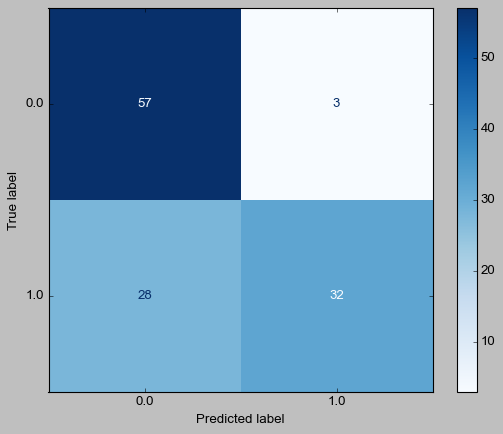

In [126]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

preds = model(xtest)>=0.5

print(classification_report(ytest, preds))

with plt.style.context('classic'):
    ConfusionMatrixDisplay.from_predictions(ytest, preds, cmap='Blues')

# Predict Submission data

In [127]:
sub_preds = model(xsub)

In [128]:
sub_preds = np.where(sub_preds >= 0.5, 'Rice', 'Non Rice')

<AxesSubplot: >

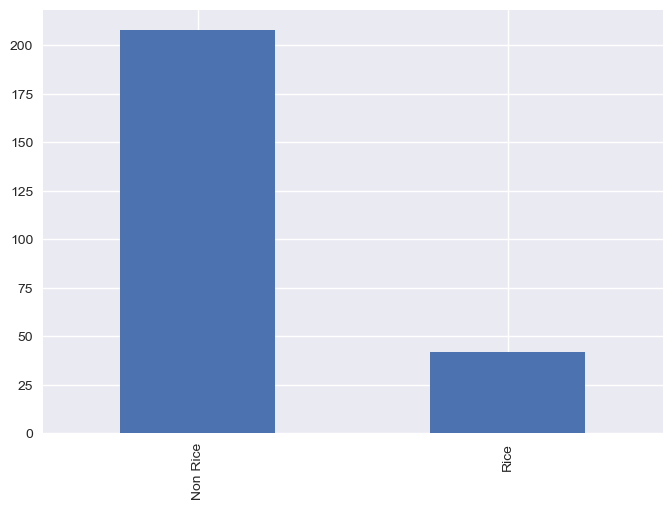

In [129]:
sub_preds = pd.Series(sub_preds.squeeze())
sub_preds.value_counts().plot.bar()

In [96]:
sub_df = pd.concat([sample_sub['Latitude and Longitude'], sub_preds], axis=1)
sub_df.columns = ['id', 'target']
sub_df

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Rice
246,"(10.582910017285496, 105.23991550078767)",Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [94]:
sub_df.to_csv('Version 1.csv', index=False)